I believe that my implementation of the Lucy-Richardson deconvolution isn't perfect. This notebook is to test the effects.

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from DeconvolvePSF.lucy import convolve, convolveStar, makeGaussian, calcChi2#, deconvolve
from skimage.restoration import richardson_lucy as rl
from subprocess import check_output
from itertools import izip
import ipywidgets

import scipy
import numpy.lib.index_tricks as itricks
import pdb
from WavefrontPSF.psf_evaluator import Moment_Evaluator
#from scipy.signal import convolve2d as convolve
#from DeconvolvePSF.lucy import deconvolve

In [10]:
import DeconvolvePSF.colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

In [11]:
# these give the deconvolved stars
out_base = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/'

dir_str = check_output('ls -d %s00*/'%out_base, shell = True) #get all the directories in our output dir
dir_list = dir_str.split('/\n')[:-1]#skip the lsat one, its ''

expids = [int(direc.lstrip('%s'%out_base) ) for direc in dir_list]
expids = sorted(expids)
bad_expid_idxs = [2,5, 6]
#14
#5
#expid = expids[0]
expid = 149440
print(expid)

#out_base = '/nfs/slac/g/ki/ki18/des/cpd/DeconvOutput/'
deconv_dir = out_base + '{0:08d}'.format(expid)
# not sure what stars these really are? the combined psfex + deconv?
deconvmodel_loc = out_base + '{0:08d}/{0}_stars.npy'.format(expid)
deconvopt_loc = out_base + '{0:08d}/{0}_opt.npy'.format(expid)
deconvatm_loc = out_base + '{0:08d}/{0}_atm.npy'.format(expid)
deconvstarsminusopt_loc = out_base + '{0:08d}/{0}_stars_minus_opt.npy'.format(expid)
deconvdata_loc = out_base + '{0:08d}/{0}_data.npy'.format(expid)
deconvpsfex_loc = out_base + '{0:08d}/{0}_psfexalone.npy'.format(expid)
deconvdf_loc = out_base + '{0:08d}/results.h5'.format(expid)
deconvdf_key = 'table_{0:08d}'.format(expid)

deconvopt_immediate_loc = '/nfs/slac/g/ki/ki18/des/swmclau2/DeconvOutput/{0:08d}/{0}_opt_test.npy'.format(expid)

jamierod_results_path = '/nfs/slac/g/ki/ki18/des/cpd/jamierod_results.csv'
mesh_directory = '/nfs/slac/g/ki/ki22/roodman/ComboMeshesv20'
# directory containing the input data files
base_directory = '/nfs/slac/g/ki/ki18/des/cpd/psfex_catalogs/SVA1_FINALCUT/psfcat/'

149440


In [12]:
#Look I'm a comment this isn't rawnb
atmpsf = np.load(deconvatm_loc)
optpsf = np.load(deconvopt_loc)
starminusopt = np.load(deconvstarsminusopt_loc)
model = np.load(deconvmodel_loc)
psfexpsf = np.load(deconvpsfex_loc)
stars = np.load(deconvdata_loc)

stars[stars < -1000] = 0

df = pd.read_hdf(deconvdf_loc, deconvdf_key)

In [13]:
MASK_VAL = -9999
good_stars = []
for idx, resid in enumerate(starminusopt):
    if not np.any(resid == MASK_VAL):
        good_stars.append(idx)
good_stars = np.array(good_stars)
print(good_stars.shape, starminusopt.shape)

((20269,), (28824, 63, 63))


In [14]:
def deconvolve(PSF,phi_tilde,psi_0=None,mask=None,mu0=0.0,niterations=10,convergence=-1,chi2Level=0.0,extra=False):
    """ Implementation of the Richardson-Lucy deconvolution algorithm.
    Notation follows Lucy 1974, Eqn 15 and 14.  Add  noise term following
    Snyder et al 1993.
    Arguments
    ---------
    PSF          known Point Spread Function
    phi_tilde    measured object
    psi_0        starting guess for deconvolution
    mask         =0 for bins where we know that recovered image has no flux 
    mu0          background noise estimate
    """

    # normalize PSF
    PSF = PSF / np.sum(PSF)

    # if no initial guess, make one from 2nd moments of input image - PSF
    if psi_0 is None:
        '''
        # calculate Moments of psi_tilde and PSF, subtract and

        # calculate moments
        evaluator = Moment_Evaluator()

        # try a better starting guess - based on our knowledge of the PSF
        image_moments = evaluator(phi_tilde)
        PSF_moments = evaluator(PSF)

        #TODO what to do if makeGaussian throws an error?
        # subtract 2nd order moments in quadrature, use an object with the difference
        Mxx = image_moments['Mxx'][0] - PSF_moments['Mxx'][0]
        Myy = image_moments['Myy'][0] - PSF_moments['Myy'][0]
        Mxy = image_moments['Mxy'][0] - PSF_moments['Mxy'][0]

        psi_r = makeGaussian(phi_tilde.shape,Mxx,Myy,Mxy)
        #sometimes this fails if the observation is too non-gaussian
        if np.any(np.logical_or( np.isinf(psi_r), np.isnan(psi_r))):
            psi_r = phi_tilde #trying this out; otherwise we'll just have to raise errors/hell
        '''
        psi_r = np.ones(PSF.shape)
    else:
        # initial guess
        psi_r = np.abs(psi_0)

    # mask starting guess
    if mask is not None:    
        psi_r = psi_r * mask

    # normalize starting guess
    psi_r = psi_r / np.sum(psi_r)
    
    #TODO Maybe this should be an error instead of a warning.
    if np.any(np.isnan(psi_r)):
        raise RuntimeWarning("NaN in initial guess, skip this value. ")
                
    # mask image too
    if mask != None:
        phi_tilde = phi_tilde * mask
        
    # find normalization for measured image
    beta = np.sum(phi_tilde)
        
    # now iterate, either until convergence reached or fixed number of iterations are done
    psiByIter = []
    diffByIter = []
    chi2ByIter = []
    iteration = 0
    prev_diffs = []
    continueTheLoop = True
    
    while continueTheLoop: 
        
        #plt.imshow(psi_r,interpolation = 'None', vmin = 0)
        #plt.show()
        
        # calculate next approximation to psi
        phi_r = beta*convolve(psi_r,PSF) + mu0
        psi_rplus1 = psi_r * convolveStar(beta*(phi_tilde)/phi_r,PSF)

        # mask the next iteration
        if mask != None:
            psi_rplus1 = psi_rplus1 * mask
        
        # normalize it
        psi_rplus1 = psi_rplus1 / np.sum(psi_rplus1)

        # check for convergence if desired
        #Why are the psiByIter appends inside the convergence test?
        if convergence>0:
            # compare psi_r and psi_rplus1
            psiByIter.append(psi_rplus1)
            diff = np.sum(np.abs(psi_rplus1 - psi_r))
            if len(prev_diffs)>1 and diff > prev_diffs[-1] > prev_diffs[-2]:
                continueTheLoop = False
                psi_rplus1 = np.ones(psi_r.shape)*-9999
            diffByIter.append(diff)
            if diff<convergence:
                continueTheLoop = False

        # also calculate how close to a solution we are
        chi2 = calcChi2(PSF,psi_rplus1,phi_tilde,beta,mu0)
        chi2ByIter.append(chi2)
        if 0<chi2<chi2Level:

            continueTheLoop = False
        
        # check for Chi2 level
                
        # always check number of iterations
        if iteration==niterations-1:
            continueTheLoop = False

        # save for next iteration
        iteration+=1     
        psi_r = np.array(psi_rplus1)  # does a deepcopy
        prev_diffs.append(diff)

    #TODO rescale deconv by flux

    # we are done!
    
    evaluator = Moment_Evaluator()

    resid_moments = evaluator(psi_rplus1)

    #TODO what to do if makeGaussian throws an error?
    # subtract 2nd order moments in quadrature, use an object with the difference
    Mxx = resid_moments['Mxx'][0]
    Myy = resid_moments['Myy'][0]
    Mxy = resid_moments['Mxy'][0]

    if any(np.isnan(x) for x in (Mxx, Myy, Mxy)):
        return np.ones(psi_rplus1.shape)*-9999

    if extra:
        return psi_rplus1,diffByIter,psiByIter,chi2ByIter
    else:
        
        return psi_rplus1  

In [18]:
from numpy.random import poisson
def plot_deconv(idx, alg = 'mine'):
      
    #norm_star = stars[idx]/np.sum(stars[idx])
    #norm_star = stars[idx]

    #background = norm_star[norm_star< norm_star.mean()+norm_star.std()]
    #print norm_star.mean(), norm_star.std()
    #background = 0.005
    #flux = 5000
    #back = flux*background
    #noise = poisson(lam = back, size = model[idx].shape)
    #model_noisy = flux*model[idx] + noise
    #mnt = model_noisy.sum()
    #model_noisy = model_noisy/mnt
    #background = model_noisy[model_noisy< model_noisy.mean()+model_noisy.std()]
    star = stars[idx]
    background = star[star< star.mean()+star.std()]
    
    if alg == 'mine':
        resid = deconvolve(optpsf[idx]/optpsf[idx].sum(), stars[idx],psi_0=None,mask=None,mu0=background.mean(),convergence=1e-2,chi2Level=0.,niterations=50, extra= False)
    else: 
        resid = rl(atmpsf[idx], model_noisy, iterations = 50, clip = True)
        
    #resid_back = resid[resid< resid.mean() + 2*resid.std()]
    
    #resid-=resid_back.mean()
    #resid[resid<0] = 0
    
    #resid = resid/resid.sum()
        
    reconv = convolve(resid, atmpsf[idx]/atmpsf[idx].sum())
        
        
    evaluator = Moment_Evaluator()

    resid_moments = evaluator(starminusopt[idx])
    true_moments = evaluator(optpsf[idx])

    e0_diff = resid_moments['Mxx'][0] - true_moments['Mxx'][0] + resid_moments['Myy'][0] - true_moments['Myy'][0]
    e1_diff = resid_moments['Mxx'][0] - true_moments['Mxx'][0] - resid_moments['Myy'][0] + true_moments['Myy'][0]
    e2_diff = 2*(resid_moments['Mxy'][0] - true_moments['Mxy'][0])
    #print 'Reconv minus True: Mxx Myy Mxy'
    #print Mxx_diff, Myy_diff, Mxy_diff   
    
    if idx%1 == 0:
        fig = plt.figure(figsize = (10,10))

        vmin = None
        vmax = None# np.max([model_noisy.max(), optpsf[idx].max(), atmpsf[idx].max(), resid.max()])
        
        plt.subplot(221)
        plt.title('Star')
        plt.imshow(stars[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(224)
        plt.title('PSFEx')
        plt.imshow(atmpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(223)
        plt.title('Resid')
        plt.imshow(resid, interpolation = 'None', vmin = vmin, vmax = vmax)
        plt.subplot(222)
        plt.title('Opt True')
        plt.imshow(optpsf[idx], interpolation = 'None', vmin = vmin, vmax = vmax )

        plt.show()
        
        print [resid_moments[x][0] for x in ('Mxx', 'Myy', 'Mxy')]
    
    
    return e0_diff, e1_diff, e2_diff

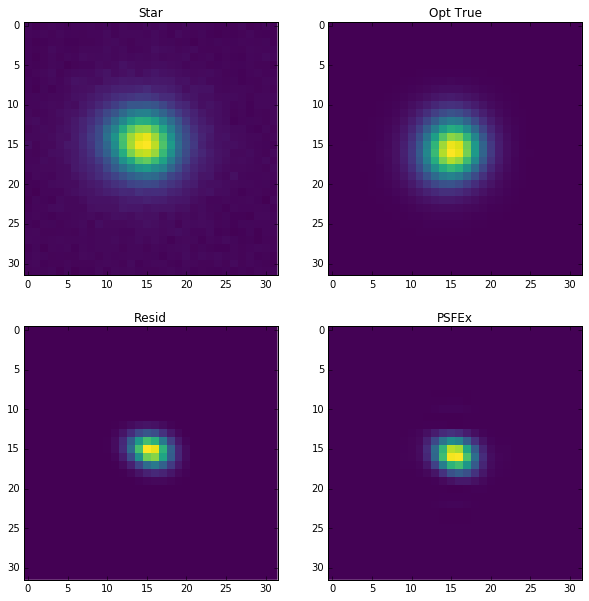

[2.8404783551159483, 1.78579683300114, 0.34958451996359041]


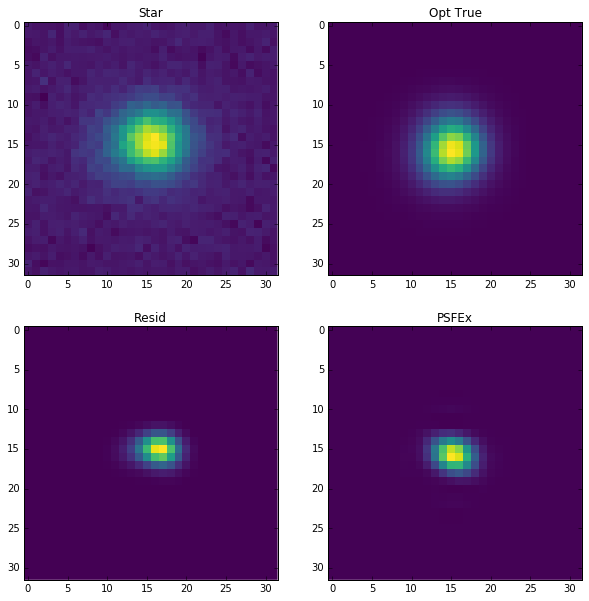

[3.183502522958666, 1.6425945509112791, 0.1142131135182223]


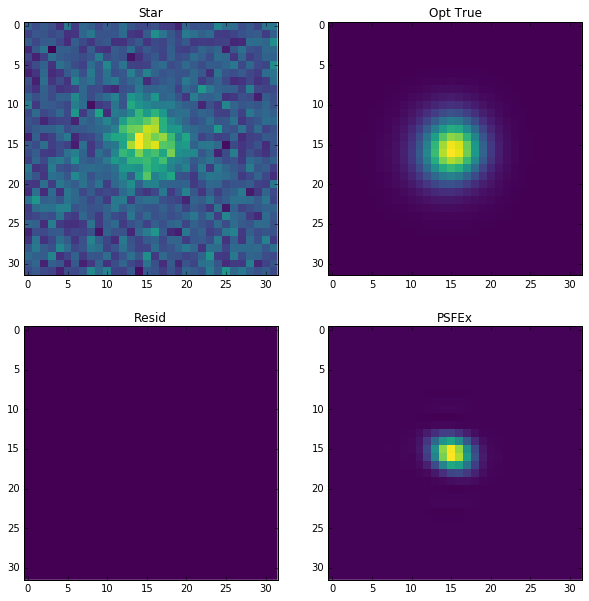

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


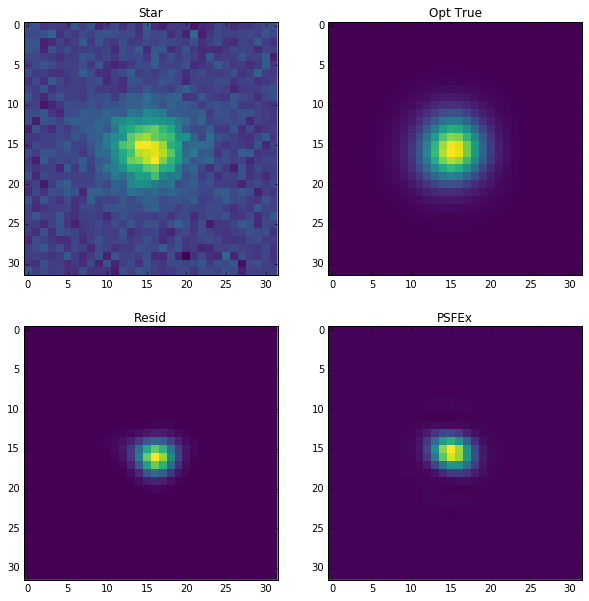

[2.5726724410738409, 1.8931643543778116, 0.038627691249276411]


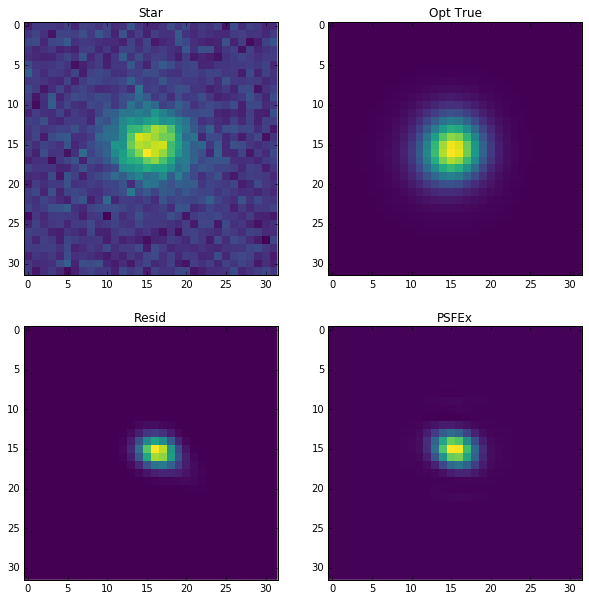

[2.6014549927139194, 1.5598406970292937, 0.34370942763920886]


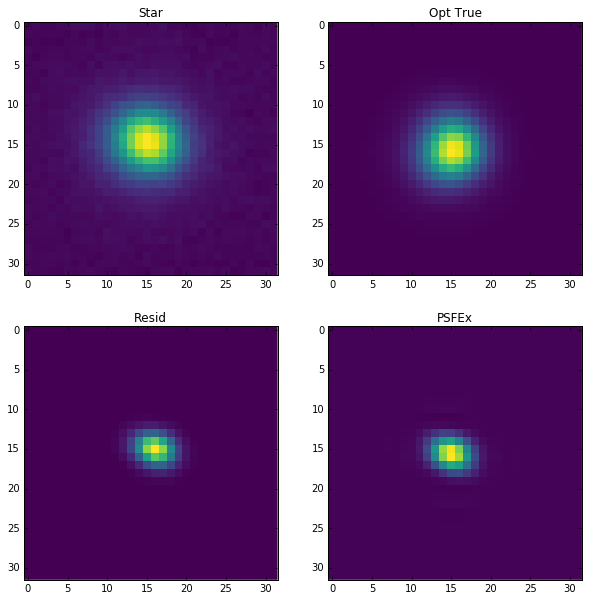

[2.8887182601162245, 1.849061598999018, 0.38358795943165036]


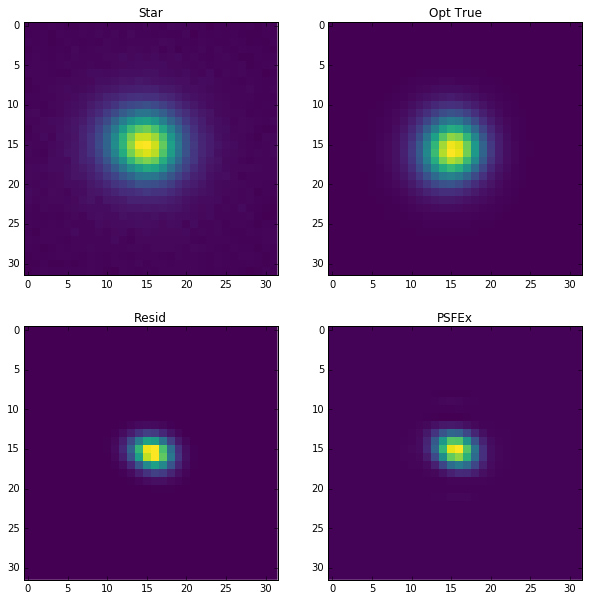

[2.8746417136714464, 1.7862556406377383, 0.33684772797158169]


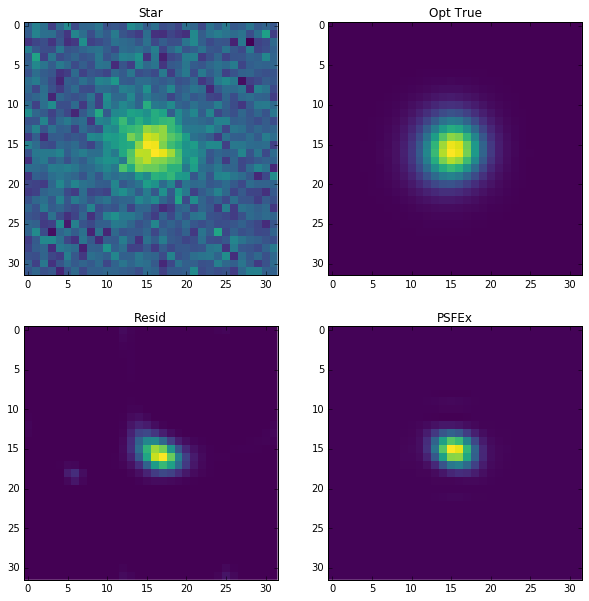

[3.4319404501800106, 1.9490336197698306, 0.89053045038394218]


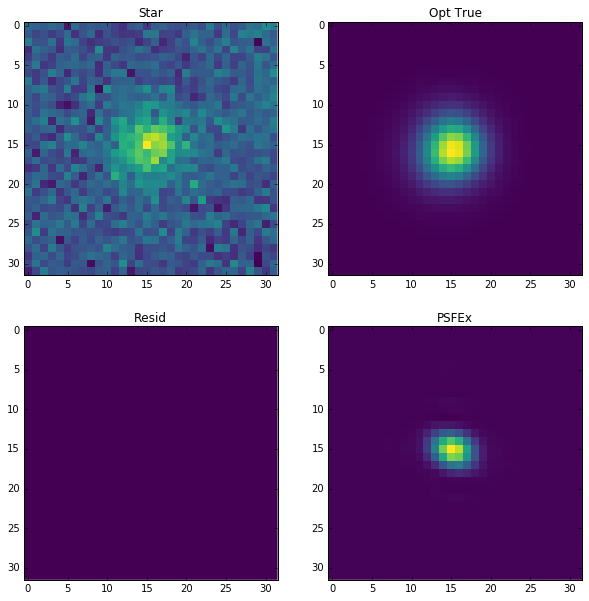

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


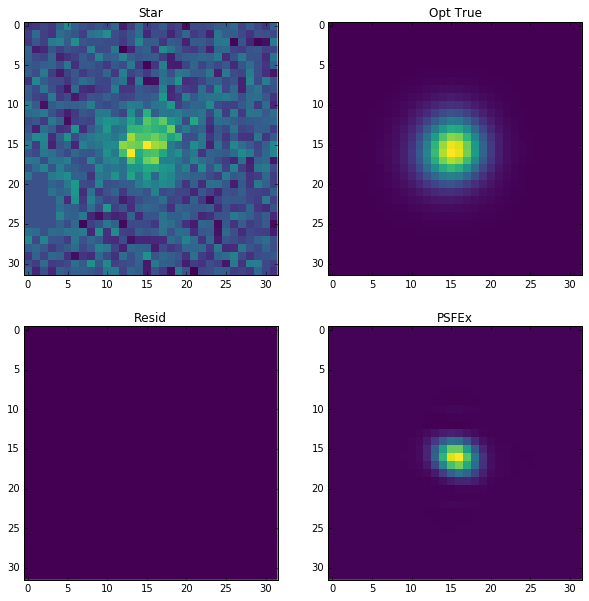

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


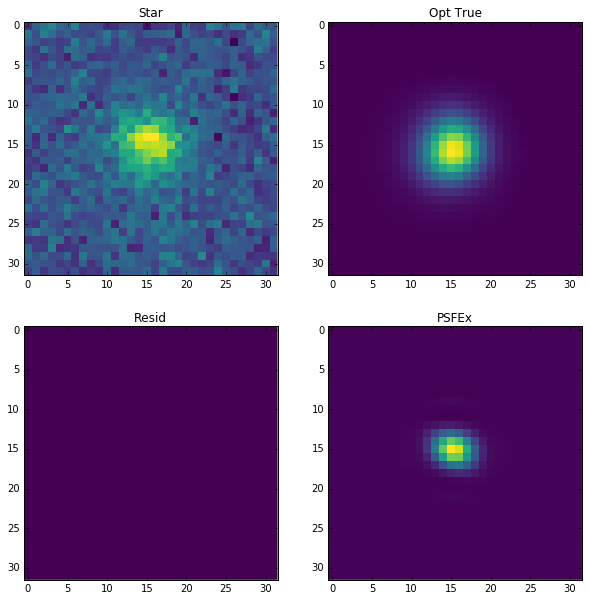

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


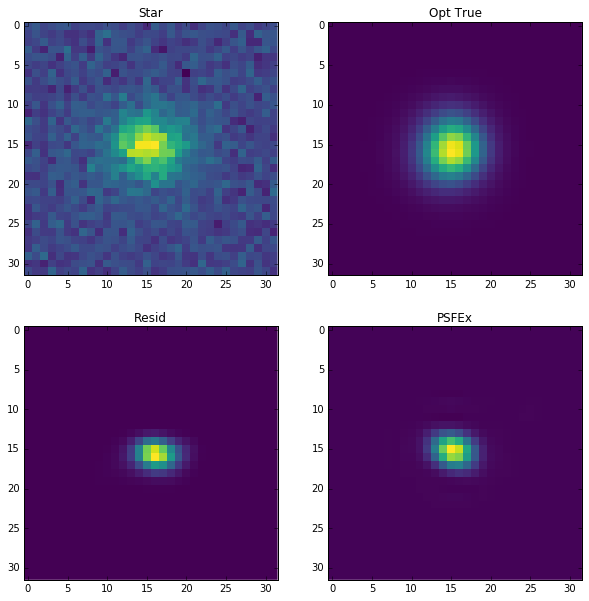

[3.1352877304335252, 1.4728966458849464, 0.15454267259186666]


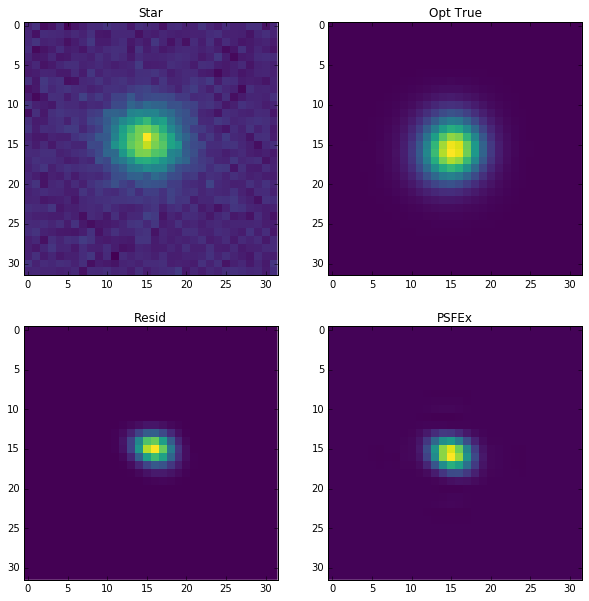

[2.66183561526526, 1.6217441325135298, 0.29360594826860975]


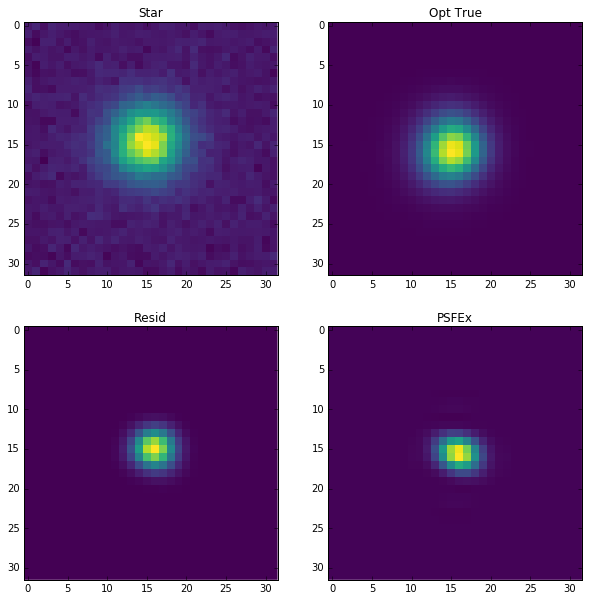

[3.0703182336860468, 2.6392948683296096, 0.038527773236401275]


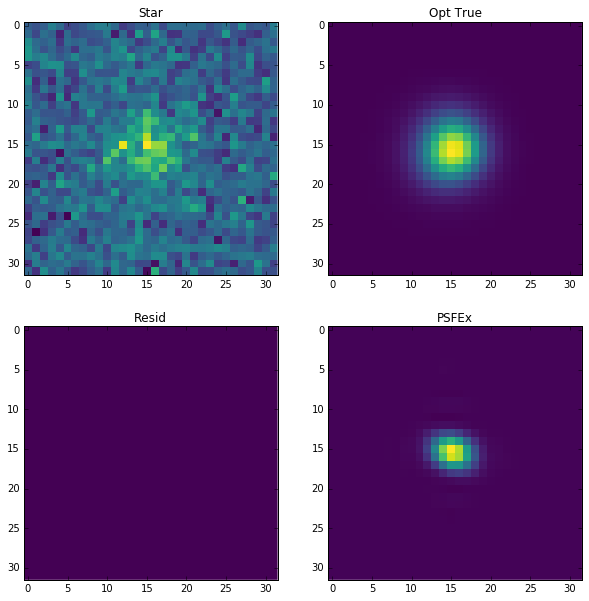

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


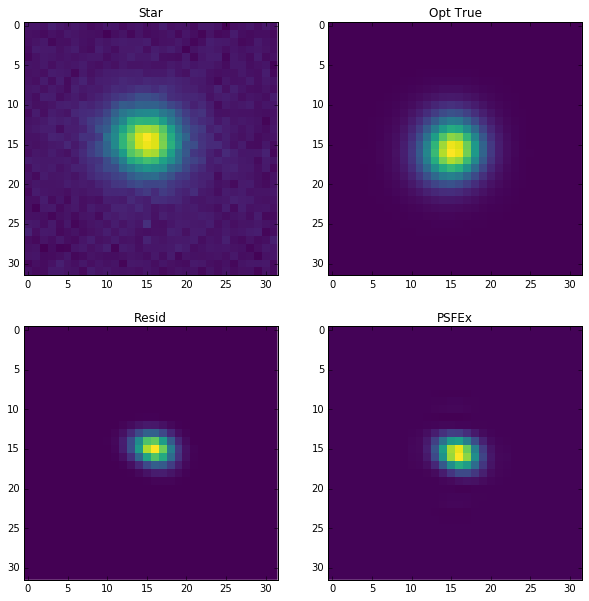

[2.8912964562680097, 1.7437104646097445, 0.37445863595663564]


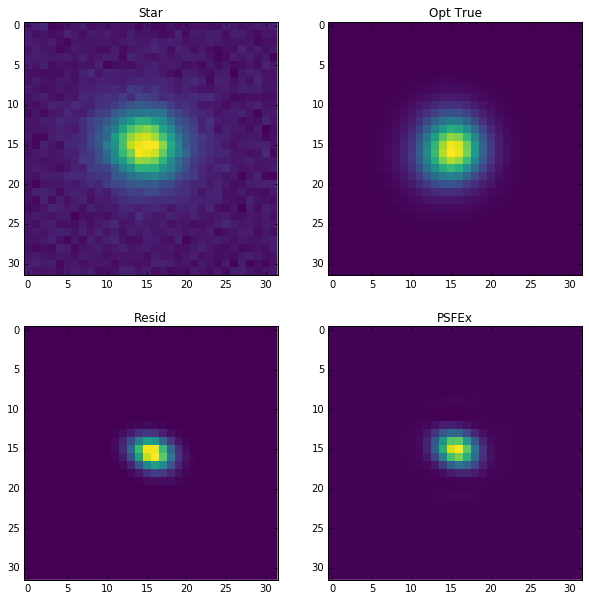

[2.9329624811721526, 1.7681087224686522, 0.44069561487547926]


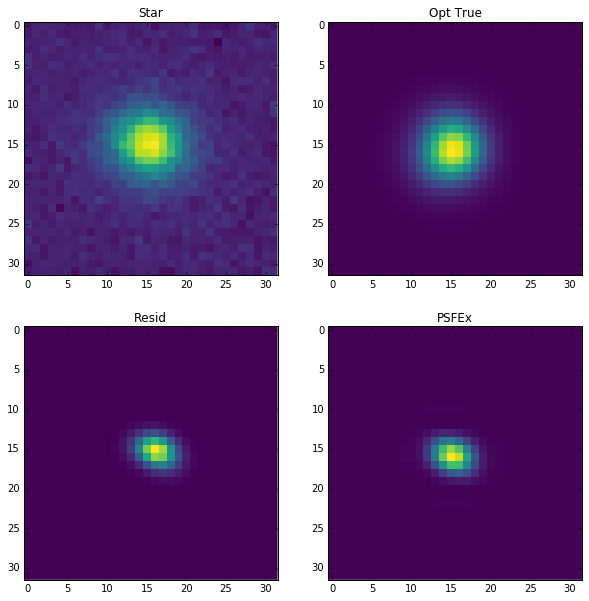

[2.9117211907588563, 1.8514169708860317, 0.48721952753563602]


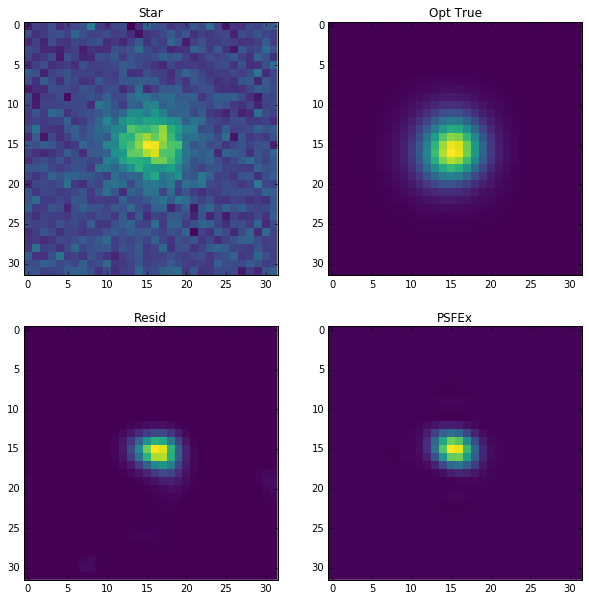

[3.3729239649235776, 2.0892486028515642, 0.33516733411747002]


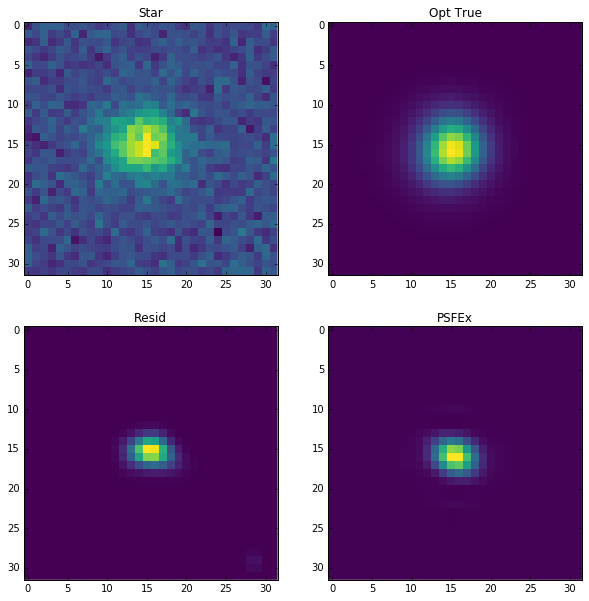

[2.8002585774093718, 1.4615116550920977, 0.19418076004003448]


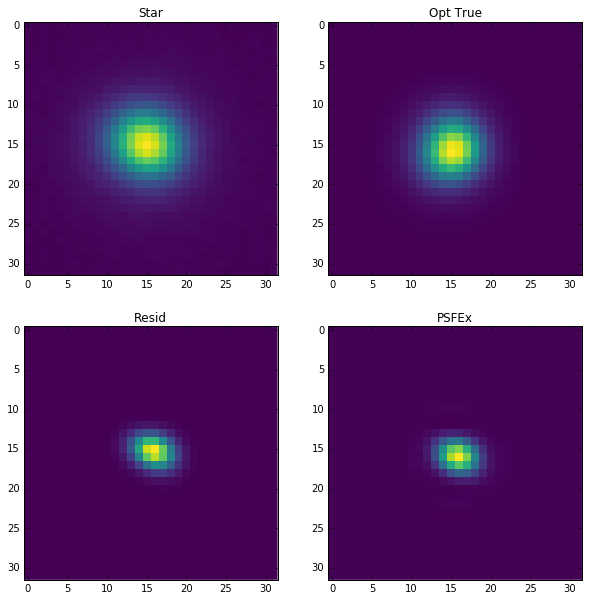

[3.1622201016112577, 2.0723161554739695, 0.52778837694666758]


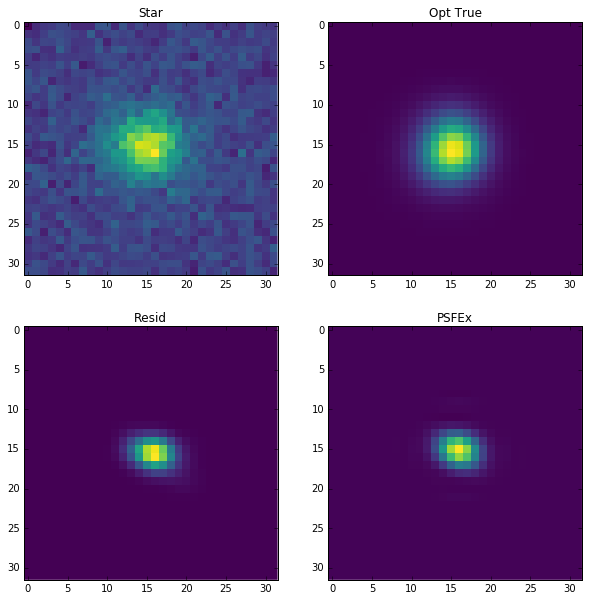

[3.2420086016083385, 1.8070942999880384, 0.3384713447541926]


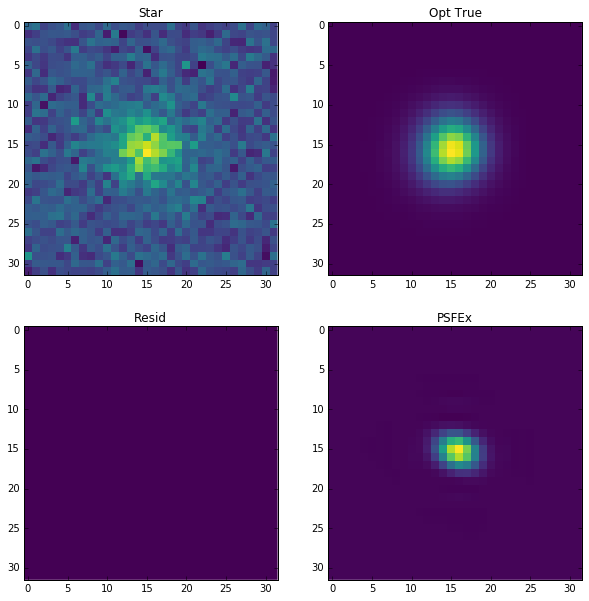

[2.9126528001278982, 1.7603378454110112, 0.48214852999195057]


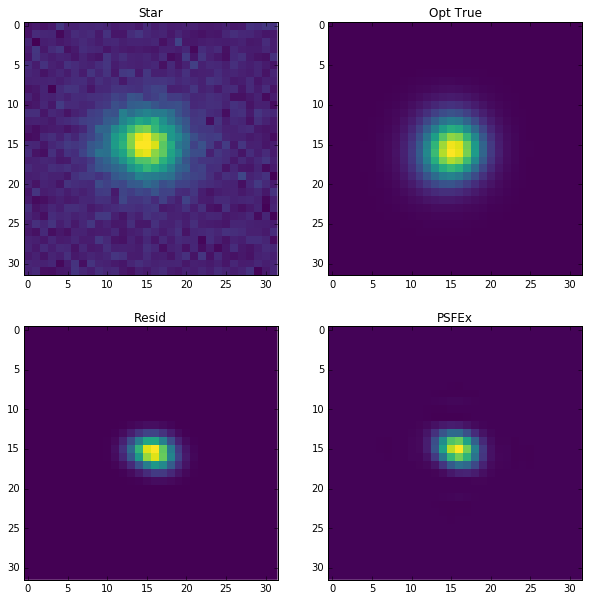

[3.2887945180046576, 1.8309811411482719, 0.34067291732124949]


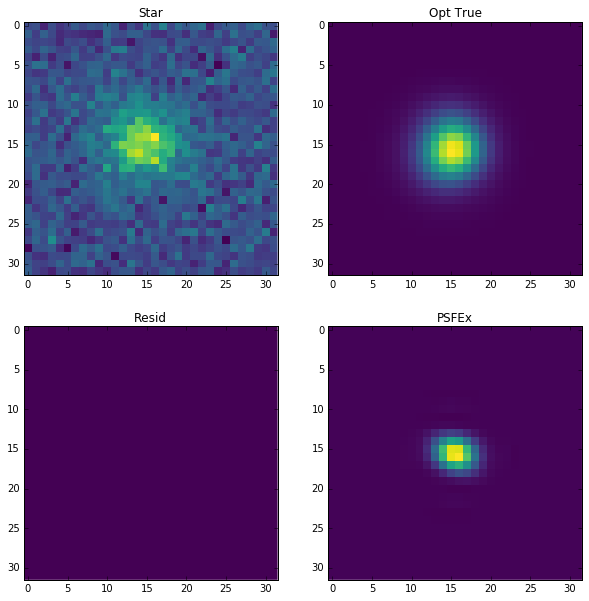

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


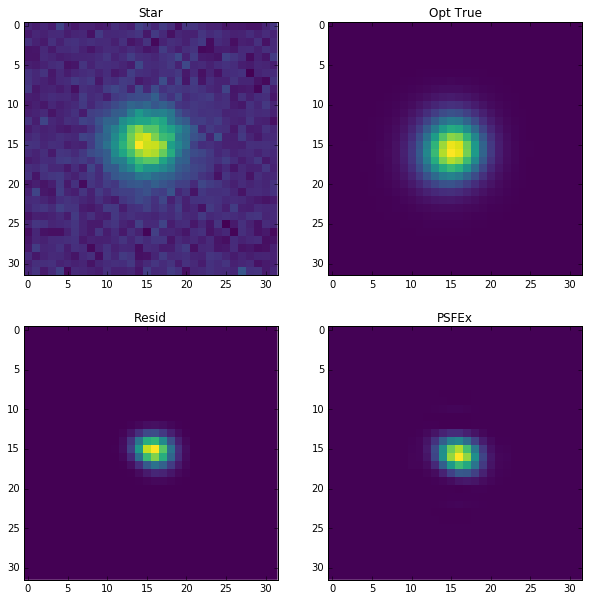

[2.4771380482172929, 1.6660319293181118, 0.21459297291953583]


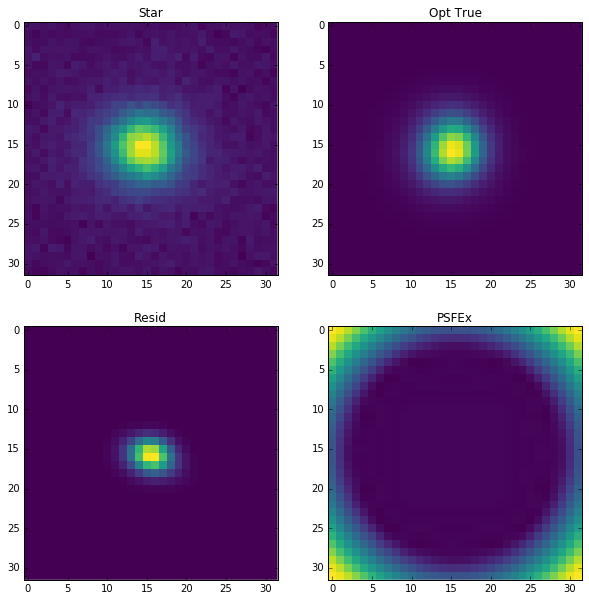

[3.266270919957301, 2.0050792084714928, 0.34518591897512185]


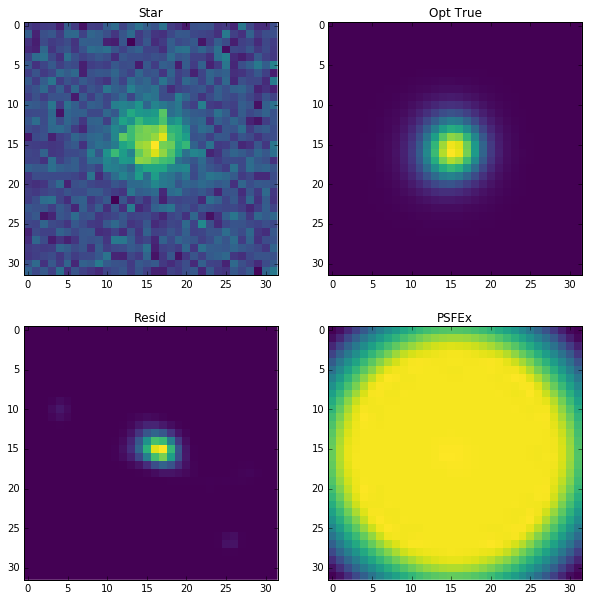

[2.615168569019612, 1.7068974335492437, 0.36915635353881526]


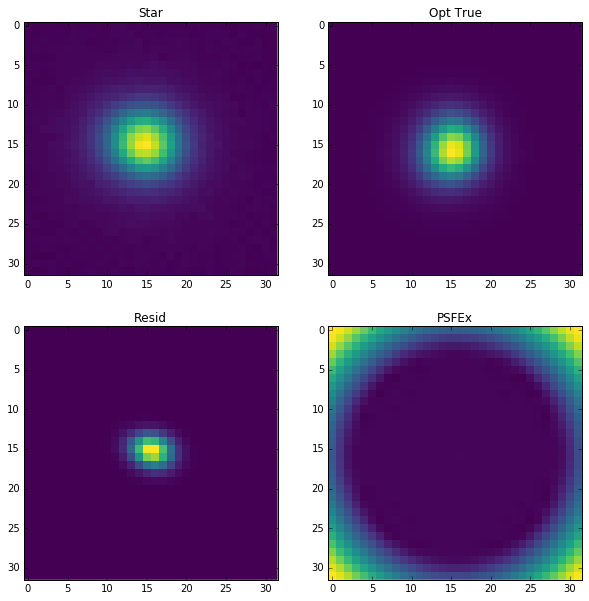

[2.9931753718419571, 1.8507823850861502, 0.32770101549663078]


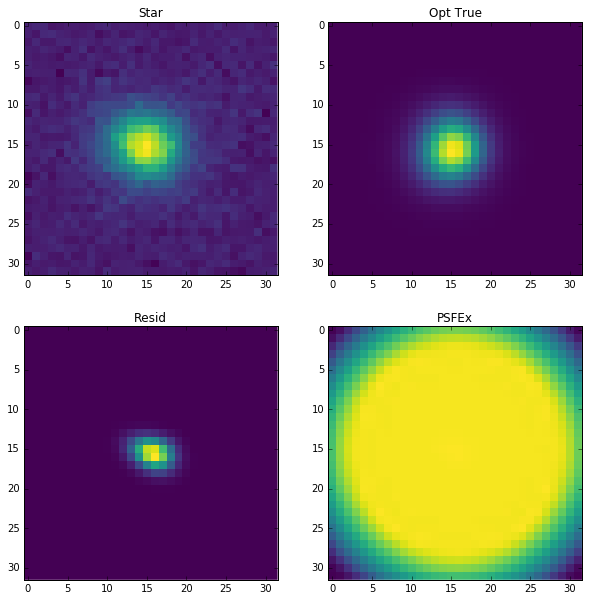

[2.9425621212511617, 1.7527215804212108, 0.49784699643012309]


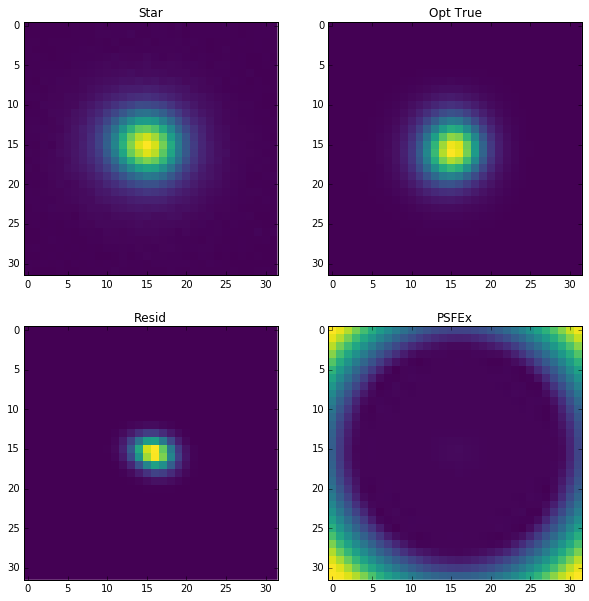

[2.9799167278522281, 1.8291208586903782, 0.34249179142409869]


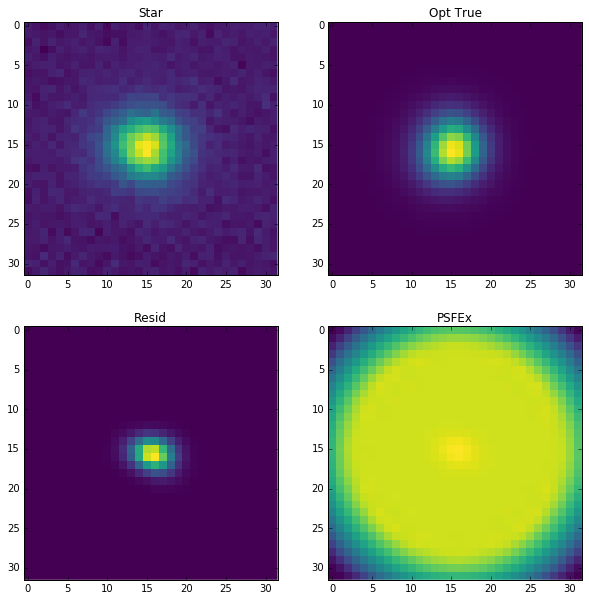

[3.1926722650607404, 1.9287494785977159, 0.33874804769810352]


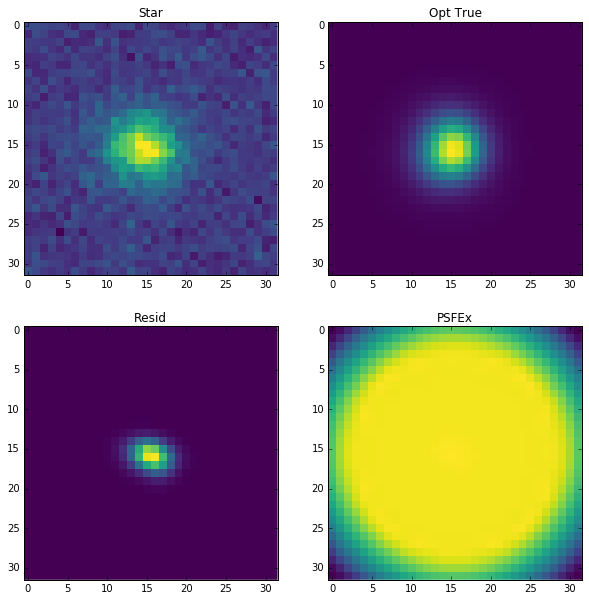

[2.9074464429798295, 1.7340259618587721, 0.46686763556535227]


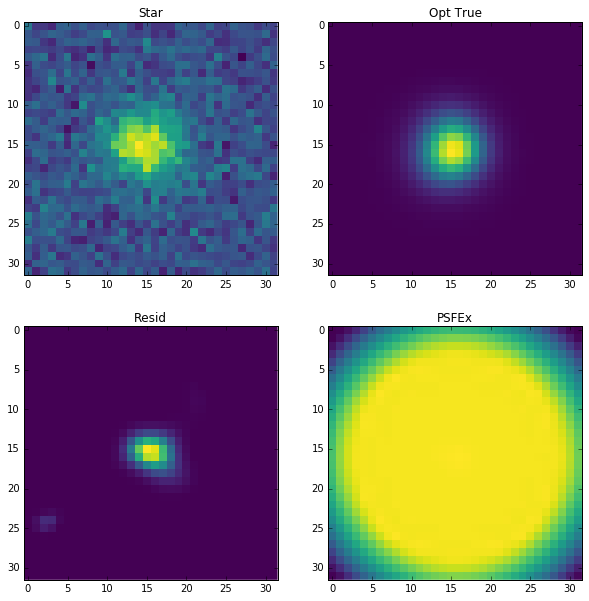

[3.2400298987144973, 2.1035439546666028, 0.46264380589801501]


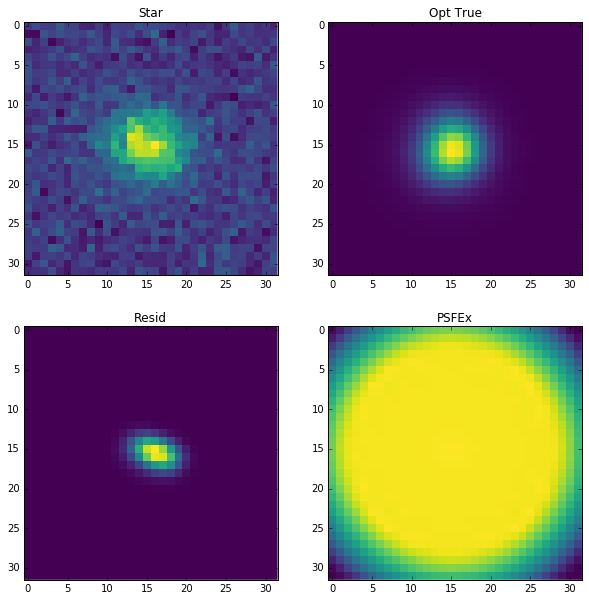

[3.8057184973824985, 1.8476306590099427, 0.80882677358778454]


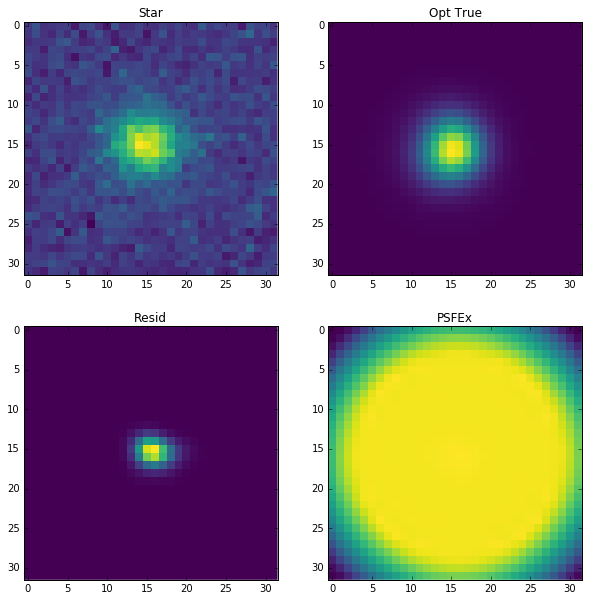

[2.4391301804342342, 1.5419834976512523, 0.20213106321507612]


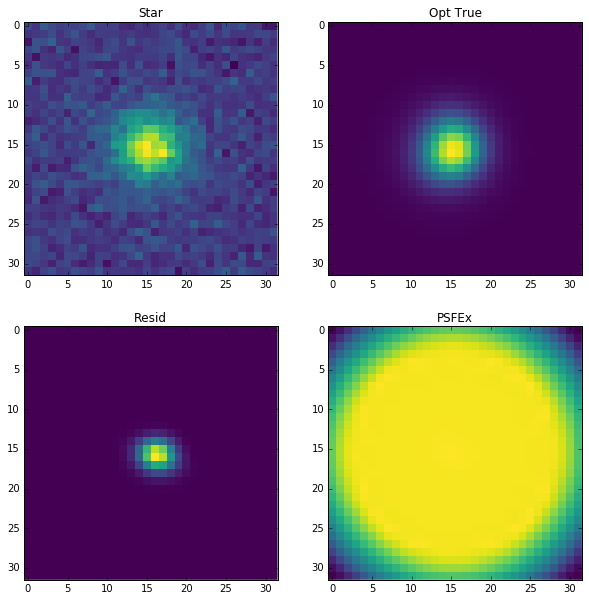

[2.4565593165638635, 1.712763576595203, 0.17243485999338642]


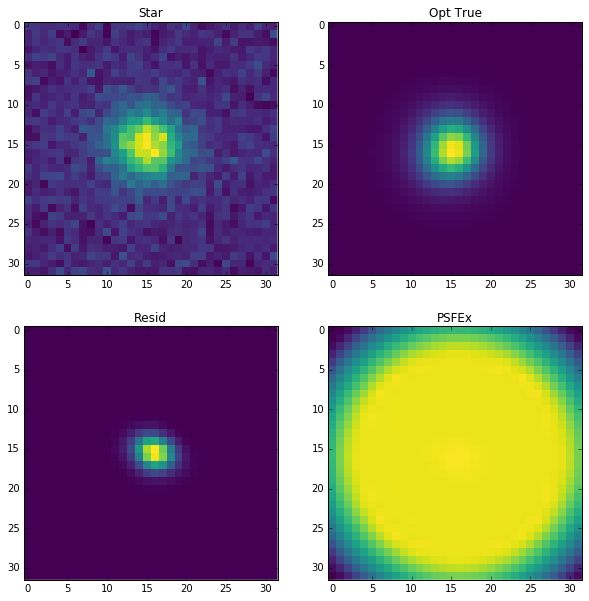

[2.8419561677287026, 2.0794648561913442, 0.38459949869782195]


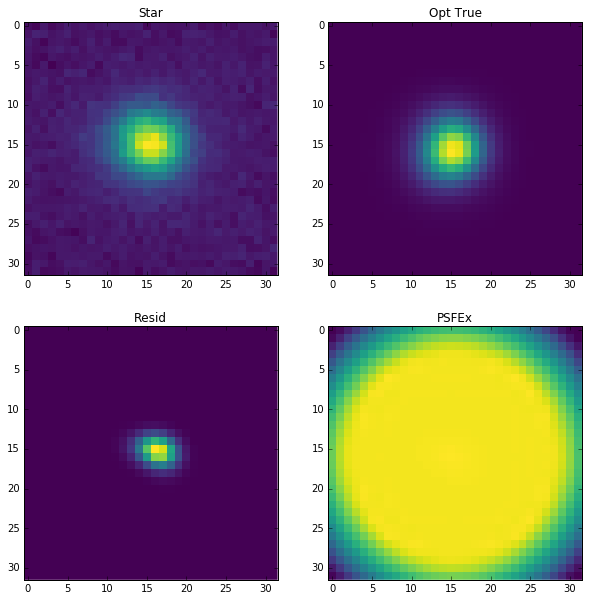

[2.7815899917830809, 1.7388050696489845, 0.37716507828192813]


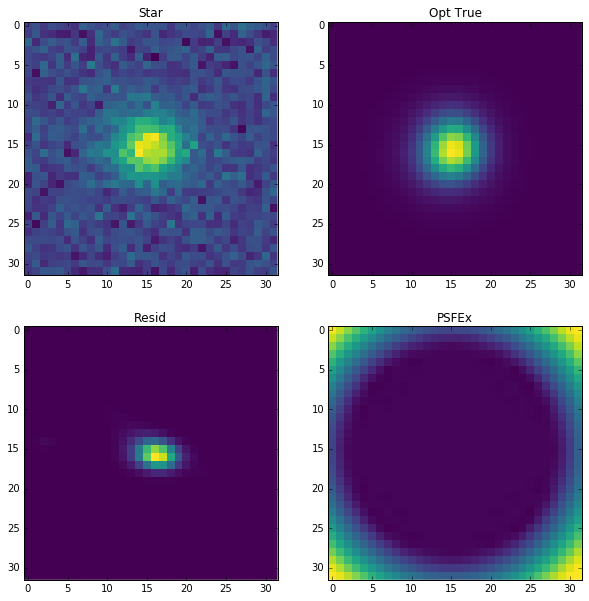

[3.0465708929912694, 1.3387988001543616, 0.30360751045791068]


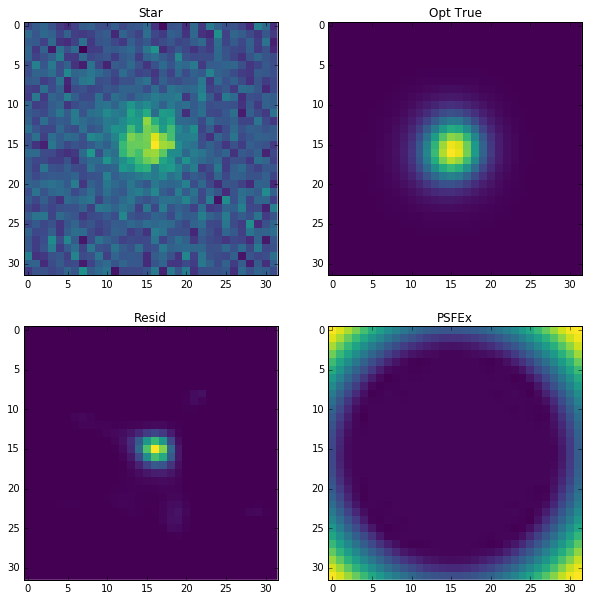

[1.9675215080974557, 1.5374439664314687, 0.19930806946242358]


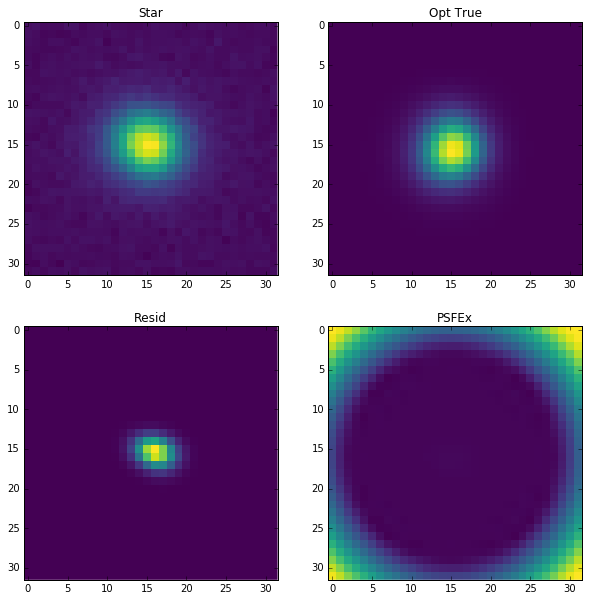

[2.814439608429939, 1.7421659190826344, 0.37499700885312237]


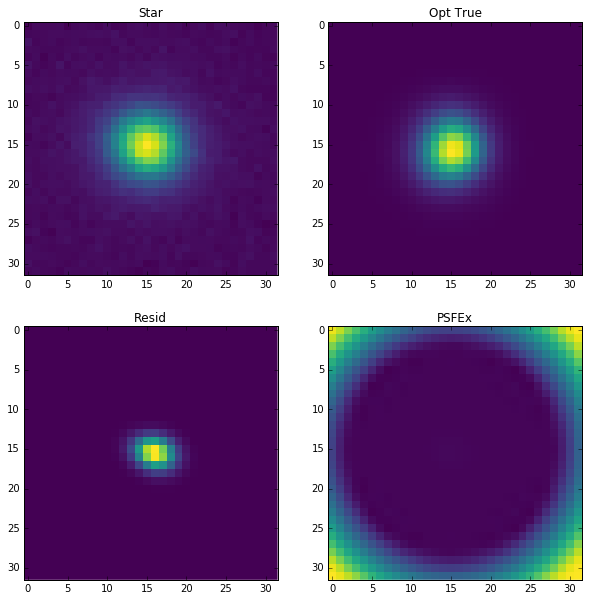

[2.8376454013429431, 1.8139281422905376, 0.34129812984855901]


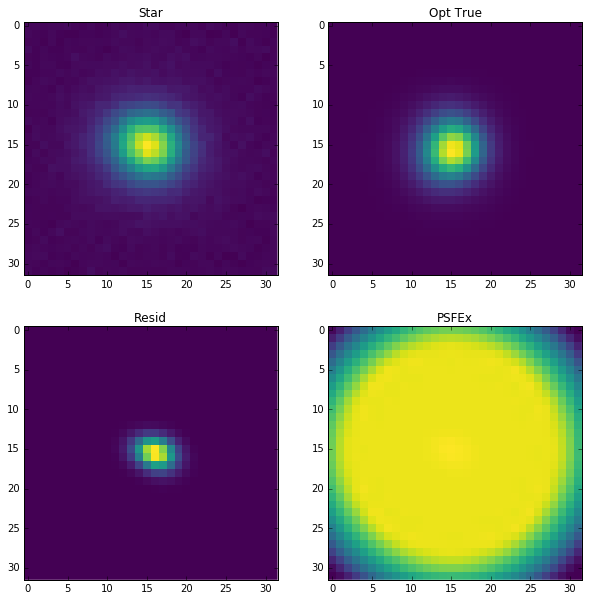

[2.9703706971245531, 1.8271300701673501, 0.40821376175787349]


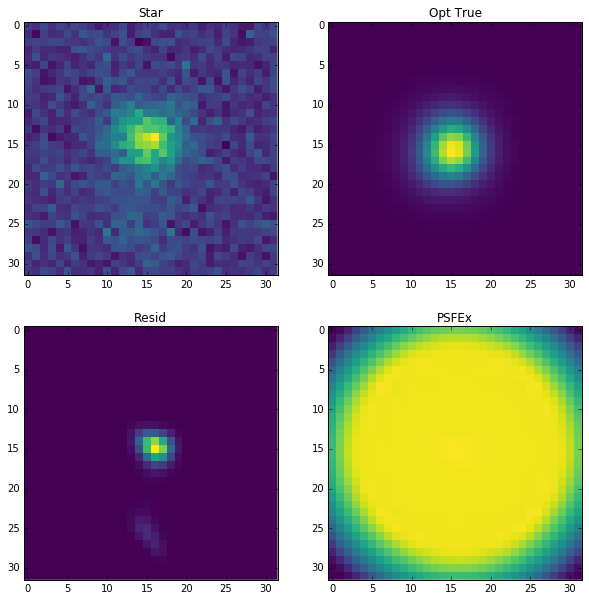

[506.22983479002335, 506.22983479002551, -2.4620522771298474e-15]


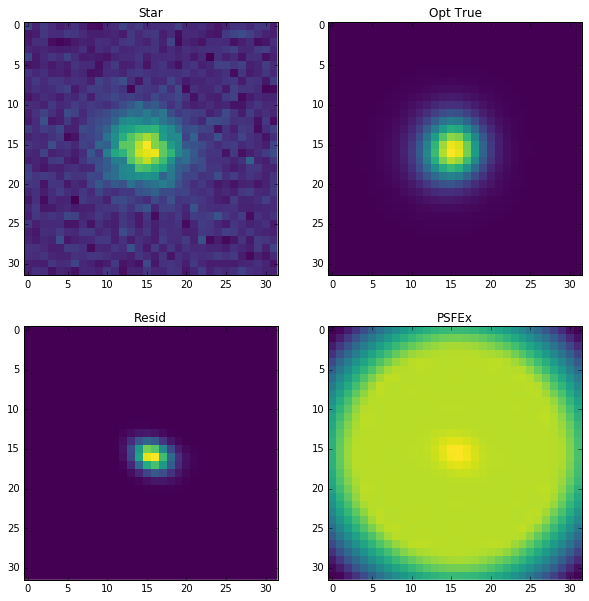

[2.5409358518430842, 1.6461271816098946, 0.43902376403342647]


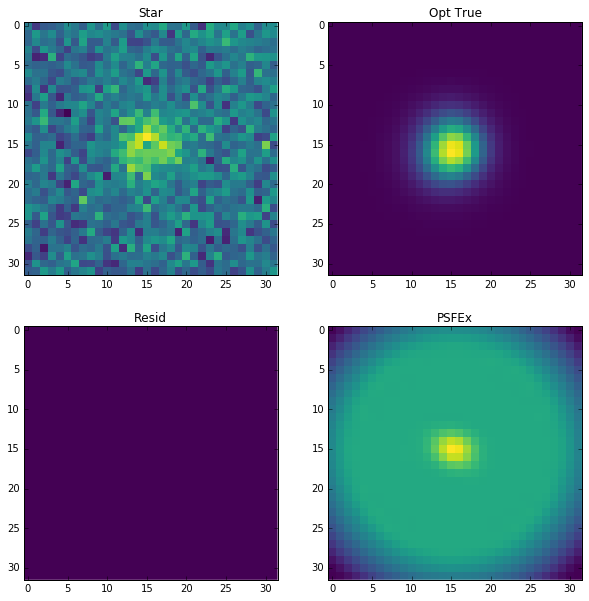

In [ ]:
#6 8 100 bad
#200 good
l = 1000#stars.shape[0]
ellip_diffs = np.zeros((l, 3) )
for idx in xrange(4500, 5500):
    diffs = plot_deconv(idx, alg = 'mine')
    ellip_diffs[idx-4500, :] = diffs

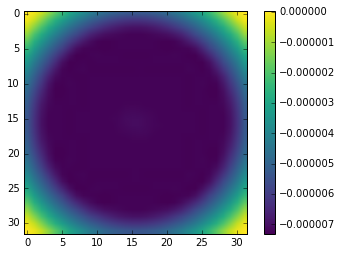

In [17]:
im = plt.imshow(atmpsf.mean(axis = 0))
plt.colorbar(im)

In [ ]:
%%bash
pwd